In [10]:
#%% env: new-ml

from array import array
from cmath import nan
from pyexpat import model
import statistics
from tkinter.ttk import Separator
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torchviz import make_dot
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
from torch.autograd import variable
from itertools import chain
from sklearn import metrics as met
import pickle
from icecream import ic

import matplotlib.pyplot as plt
import pathlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from importlib import reload
# import util
# import model_torch_simple
# from torchmetrics import Accuracy
from tqdm import tqdm   
import argparse
from icecream import ic
import numpy as np
from PIL import Image
device = 'cuda' if torch.cuda.is_available() else 'cpu'

import numpy as np
import pandas as pd
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#%%
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
seed = 42
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

# train_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/aa_data_train_gene.csv', delimiter = ',')
# train_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/mic_aa_train_hml.csv')
# train_target = train_target[['EMB_MIC']]
# # don't touch test data, split out validation data from training data during training
# # test_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_EMB/aa_data_test_pca4k.csv', delimiter = ',')
# test_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/aa_data_test_gene.csv', delimiter = ',')
# test_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/mic_aa_test_hml.csv')
# test_target = test_target[['EMB_MIC']]

# all_data = np.concatenate((train_data, test_data), axis=0)
# all_target = pd.concat((train_target, test_target), axis=0)

# train_data, test_data, train_target, test_target = train_test_split(all_data, all_target, test_size=0.2, random_state=42, stratify=all_target)

In [6]:

def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')
    
def value_counts_list(lst):
    """
    Computes the frequency count of unique elements in a list and returns a dictionary, sorted by frequency count in
    descending order.

    Args:
    - lst (list): List of elements

    Returns:
    - dict: Dictionary with unique elements as keys and their frequency count as values, sorted by frequency count
      in descending order
    """
    value_counts = {}
    for item in lst:
        if item in value_counts:
            value_counts[item] += 1
        else:
            value_counts[item] = 1
    sorted_value_counts = dict(sorted(value_counts.items(), key=lambda x: x[1], reverse=True))
    return sorted_value_counts 

### dataloading

In [7]:
clinical_lung = pd.read_csv('/mnt/storageG1/lwang/Projects/TBpt/Analysis/clinical_lung_na11182024.csv')
clinical_lung.drop(columns=['condition_id'], inplace=True)

country_mapping = {
    'China': 1,        # High medical capacity, large infrastructure, advanced technology
    'India': 2,        # Large infrastructure, but strained capacity due to population
    'South Africa': 3, # Developed healthcare, but regional disparities
    'Romania': 4,      # Developing EU healthcare standards
    'Ukraine': 5,      # Moderate capacity but strained due to recent conflicts
    'Belarus': 6,      # Moderate capacity, state-funded healthcare
    'Kazakhstan': 7,   # Developing healthcare system
    'Azerbaijan': 8,   # Developing healthcare system
    'Georgia': 9,      # Smaller healthcare capacity, improving
    'Moldova': 10,     # Limited resources, developing healthcare
    'Kyrgyzstan': 11,  # Limited resources, developing healthcare
    'Nigeria': 12,     # Limited healthcare capacity, large population challenges
    'Senegal': 13      # Developing healthcare system with limited resources
}

# Apply the mapping to the 'country' column
clinical_lung['country'] = clinical_lung['country'].replace(country_mapping).fillna(0)
clinical_lung_cleaned = clinical_lung.drop_duplicates()
clinical_lung_features = clinical_lung.drop(columns=['outcome', 'period_span.1'])
clinical_lung_target = clinical_lung[['outcome']]

#### xgb training func

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_xgboost_classifier(features, target, test_size=0.2, random_state=42):
    """
    Trains and evaluates an XGBoost classifier on the provided dataset.

    Parameters:
    - features (pd.DataFrame): The feature set.
    - target (pd.Series): The target variable.
    - test_size (float): Proportion of the dataset to include in the test split.
    - random_state (int): Random seed for reproducibility.

    Returns:
    - model (XGBClassifier): The trained XGBoost model.
    - metrics (dict): A dictionary containing accuracy, sensitivity, and specificity.
    """

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=test_size, random_state=random_state, stratify=target, shuffle=True
    )

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform both training and testing data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert the scaled arrays back to DataFrames to retain feature names
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features.columns)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features.columns)

    # Initialize and train the XGBoost classifier
    model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=random_state)
    model.fit(X_train_scaled_df, y_train)

    # Predict on training and testing data
    y_train_pred = model.predict(X_train_scaled_df)
    y_test_pred = model.predict(X_test_scaled_df)

    # Calculate accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Calculate sensitivity (recall) and specificity
    sensitivity = recall_score(y_test, y_test_pred, pos_label=1)
    specificity = recall_score(y_test, y_test_pred, pos_label=0)

    # Compile metrics into a dictionary
    metrics = {
        # 'Training Accuracy': train_accuracy,
        'Testing Accuracy': test_accuracy,
        'Sensitivity (Recall)': sensitivity,
        'Specificity': specificity
    }

    # Print metrics
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value:.4f}")

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # Plot feature importance
    plt.figure(figsize=(15, 25))
    plot_importance(model, max_num_features=20, importance_type='weight', xlabel='Feature Importance')
    plt.title('Top 20 Feature Importances')
    plt.show()

    return model, metrics

# Example usage:
# Assuming 'clinical_lung_features' is your DataFrame of features
# and 'clinical_lung_target' is your target variable
# model, metrics = evaluate_xgboost_classifier(clinical_lung_features, clinical_lung_target)
import pandas as pd
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_xgboost_classifier_split(X_train, X_test, y_train, y_test, reg_alpha=0.1, reg_lambda=0.1, random_state=42):
    """
    Trains and evaluates an XGBoost classifier on the provided training and testing datasets.

    Parameters:
    - X_train (pd.DataFrame): Training feature set.
    - X_test (pd.DataFrame): Testing feature set.
    - y_train (pd.Series or np.array): Training target variable.
    - y_test (pd.Series or np.array): Testing target variable.
    - random_state (int): Random seed for reproducibility.

    Returns:
    - model (XGBClassifier): The trained XGBoost model.
    - metrics (dict): A dictionary containing accuracy, sensitivity, and specificity.
    """

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform both training and testing data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert the scaled arrays back to DataFrames to retain feature names
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    # Initialize and train the XGBoost classifier
    model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=random_state, reg_alpha=reg_alpha, reg_lambda=reg_lambda)
    model.fit(X_train_scaled_df, y_train)

    # Predict on training and testing data
    y_train_pred = model.predict(X_train_scaled_df)
    y_test_pred = model.predict(X_test_scaled_df)

    # Calculate accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Calculate sensitivity (recall) and specificity
    sensitivity = recall_score(y_test, y_test_pred, pos_label=1)
    specificity = recall_score(y_test, y_test_pred, pos_label=0)

    # Compile metrics into a dictionary
    metrics = {
        # 'Training Accuracy': train_accuracy,
        'Testing Accuracy': test_accuracy,
        'Sensitivity (Recall)': sensitivity,
        'Specificity': specificity
    }

    # Print metrics
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value:.4f}")

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # Plot feature importance
    plt.figure(figsize=(15, 25))
    plot_importance(model, max_num_features=20, importance_type='weight', xlabel='Feature Importance')
    plt.title('Top 20 Feature Importances')
    plt.show()

    return model, metrics


### current best working solution


Testing Accuracy: 0.9110
Sensitivity (Recall): 0.9234
Specificity: 0.8618


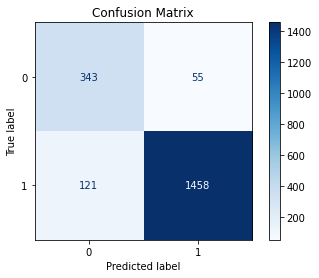

<Figure size 1080x1800 with 0 Axes>

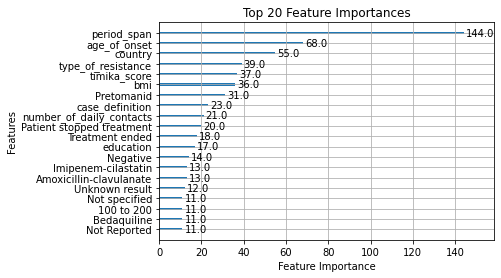

(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='mlogloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=None, num_parallel_tree=None, random_state=42, ...),
 {'Testing Accuracy': 0.9109762266059687,
  'Sensitivity (Recall)': 0.9233692210259657,
  'Specificity': 0.8618090452261307})

In [ ]:
imputer = SimpleImputer(strategy='most_frequent')

# Fit the imputer on the data and transform it
clinical_lung_features_imputed = imputer.fit_transform(clinical_lung_features)

# Convert the result back to a DataFrame
clinical_lung_features_imputed_df = pd.DataFrame(clinical_lung_features_imputed, columns=clinical_lung_features.columns)

# Optionally, replace the original DataFrame with the imputed one
clinical_lung_features = clinical_lung_features_imputed_df

import pandas as pd
from sklearn.utils import resample

# Assuming 'clinical_lung' is your DataFrame and 'outcome' is the target column
X_train, X_test, y_train, y_test = train_test_split(
    clinical_lung_features, clinical_lung_target, test_size=0.2, random_state=42, stratify=clinical_lung_target, shuffle=True
)

from imblearn.over_sampling import RandomOverSampler

# Initialize the RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Fit and resample the training data
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# evaluate_xgboost_classifier_split(X_train_resampled, X_test, y_train_resampled, y_test, reg_alpha=0.3, reg_lambda=19,  random_state=42)
evaluate_xgboost_classifier_split(X_train_resampled, X_test, y_train_resampled, y_test, reg_alpha=38, reg_lambda=69,  random_state=42)

## bagging

#### emsemble

Bagging XGBoost Performance:
Accuracy: 0.9186
Sensitivity (Recall): 0.9322
Specificity: 0.8643


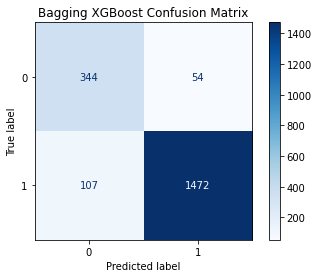

Bagging MLP Performance:
Accuracy: 0.9236
Sensitivity (Recall): 0.9563
Specificity: 0.7940


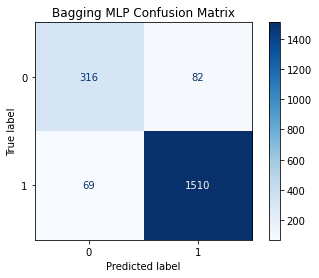

Bagging Logistic Regression Performance:
Accuracy: 0.8690
Sensitivity (Recall): 0.8822
Specificity: 0.8166


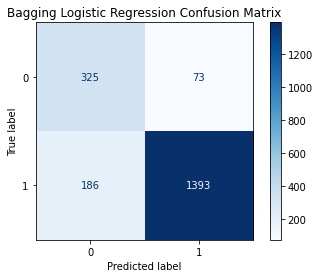

Bagging SVM Performance:
Accuracy: 0.9054
Sensitivity (Recall): 0.9322
Specificity: 0.7990


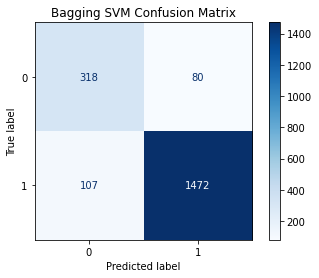

Bagging KNN Performance:
Accuracy: 0.7972
Sensitivity (Recall): 0.8309
Specificity: 0.6633


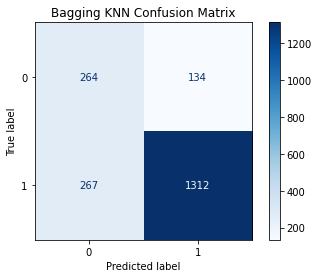

Combined Model Performance:
Accuracy: 0.9221
Sensitivity (Recall): 0.9449
Specificity: 0.8317


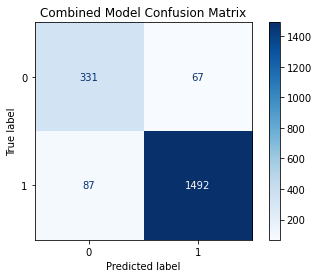

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Separate features and target
X = clinical_lung.drop(columns=['outcome'])
y = clinical_lung['outcome']


imputer = SimpleImputer(strategy='most_frequent')

# Fit the imputer on the data and transform it
X_ = imputer.fit_transform(X)

# Convert the result back to a DataFrame
X = pd.DataFrame(X_, columns=X.columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

from imblearn.over_sampling import RandomOverSampler

# Initialize the RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Fit and resample the training data
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# XGBoost classifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, reg_alpha=38, reg_lambda=69)

# MLP classifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(100, 100, 70, 70, 50, 30), max_iter=300, random_state=42)

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# SVM
svm_clf = SVC(probability=True, random_state=42)

# KNN
knn_clf = KNeighborsClassifier(n_neighbors=5)

# Bagging Classifiers
bagging_xgb = BaggingClassifier(base_estimator=xgb_clf, n_estimators=10, random_state=42)
bagging_mlp = BaggingClassifier(base_estimator=mlp_clf, n_estimators=10, random_state=42)
bagging_log_reg = BaggingClassifier(base_estimator=log_reg, n_estimators=10, random_state=42)
bagging_svm = BaggingClassifier(base_estimator=svm_clf, n_estimators=10, random_state=42)
bagging_knn = BaggingClassifier(base_estimator=knn_clf, n_estimators=10, random_state=42)

# Fit Models
bagging_xgb.fit(X_train_scaled, y_train_resampled)
bagging_mlp.fit(X_train_scaled, y_train_resampled)
bagging_log_reg.fit(X_train_scaled, y_train_resampled)
bagging_svm.fit(X_train_scaled, y_train_resampled)
bagging_knn.fit(X_train_scaled, y_train_resampled)

# Evaluate Models
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred, pos_label=1)
    specificity = recall_score(y_test, y_pred, pos_label=0)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

# Evaluate individual models
evaluate_model(bagging_xgb, X_test_scaled, y_test, "Bagging XGBoost")
evaluate_model(bagging_mlp, X_test_scaled, y_test, "Bagging MLP")
evaluate_model(bagging_log_reg, X_test_scaled, y_test, "Bagging Logistic Regression")
evaluate_model(bagging_svm, X_test_scaled, y_test, "Bagging SVM")
evaluate_model(bagging_knn, X_test_scaled, y_test, "Bagging KNN")

# Combine Predictions
xgb_probs = bagging_xgb.predict_proba(X_test_scaled)[:, 1]
mlp_probs = bagging_mlp.predict_proba(X_test_scaled)[:, 1]
log_reg_probs = bagging_log_reg.predict_proba(X_test_scaled)[:, 1]
svm_probs = bagging_svm.predict_proba(X_test_scaled)[:, 1]
knn_probs = bagging_knn.predict_proba(X_test_scaled)[:, 1]

# Average the probabilities
avg_probs = (xgb_probs + mlp_probs + log_reg_probs + svm_probs + knn_probs) / 5

# Convert averaged probabilities to class labels
avg_pred = np.where(avg_probs >= 0.5, 1, 0)

# Evaluate Combined Model
accuracy = accuracy_score(y_test, avg_pred)
sensitivity = recall_score(y_test, avg_pred, pos_label=1)
specificity = recall_score(y_test, avg_pred, pos_label=0)
cm = confusion_matrix(y_test, avg_pred)

print("Combined Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=bagging_xgb.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Combined Model Confusion Matrix')
plt.show()


bagging is not working better than xgb alone

#### larger emsemble

Bagging XGBoost Performance:
Accuracy: 0.9186
Sensitivity (Recall): 0.9322
Specificity: 0.8643


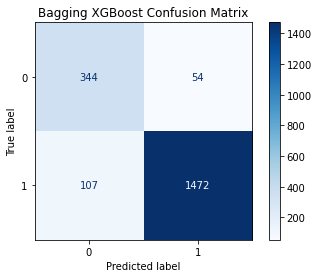

Bagging MLP Performance:
Accuracy: 0.9236
Sensitivity (Recall): 0.9563
Specificity: 0.7940


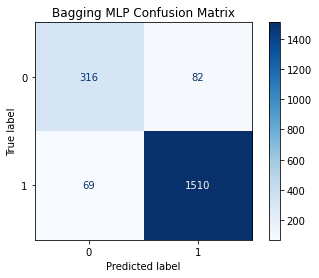

Bagging Logistic Regression Performance:
Accuracy: 0.8690
Sensitivity (Recall): 0.8822
Specificity: 0.8166


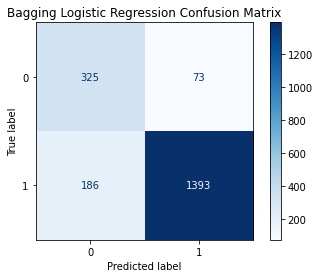

Bagging SVM Performance:
Accuracy: 0.9054
Sensitivity (Recall): 0.9322
Specificity: 0.7990


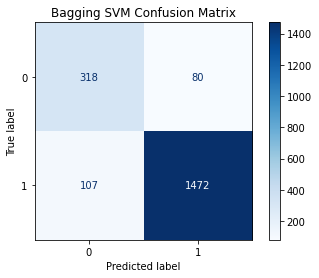

Bagging KNN Performance:
Accuracy: 0.7972
Sensitivity (Recall): 0.8309
Specificity: 0.6633


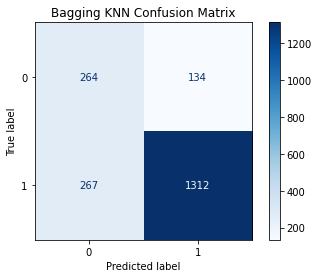

Bagging Decision Tree Performance:
Accuracy: 0.9196
Sensitivity (Recall): 0.9474
Specificity: 0.8090


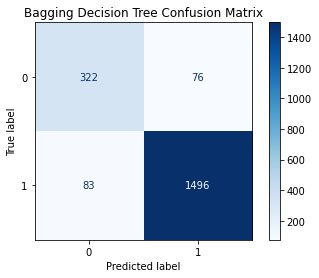

Bagging Naive Bayes Performance:
Accuracy: 0.2377
Sensitivity (Recall): 0.0494
Specificity: 0.9849


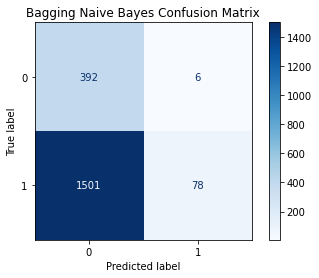

Bagging Gradient Boosting Performance:
Accuracy: 0.9125
Sensitivity (Recall): 0.9272
Specificity: 0.8543


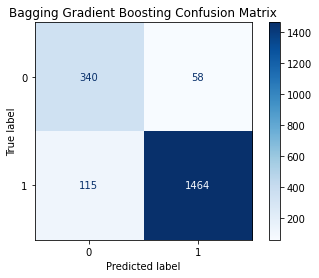

Combined Model Performance:
Accuracy: 0.9196
Sensitivity (Recall): 0.9335
Specificity: 0.8643


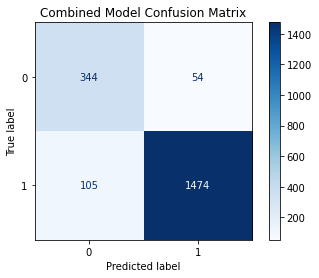

In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler

# Assuming 'clinical_lung' is your DataFrame and 'outcome' is the target column
X = clinical_lung.drop(columns=['outcome'])
y = clinical_lung['outcome']

# Impute missing values using the most frequent strategy
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Address class imbalance with RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Initialize classifiers
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, reg_alpha=38, reg_lambda=69)
mlp_clf = MLPClassifier(hidden_layer_sizes=(100, 100, 70, 70, 50, 30), max_iter=300, random_state=42)
log_reg = LogisticRegression(max_iter=1000, random_state=42)
svm_clf = SVC(probability=True, random_state=42)
knn_clf = KNeighborsClassifier(n_neighbors=5)
dt_clf = DecisionTreeClassifier(random_state=42)
nb_clf = GaussianNB()
gb_clf = GradientBoostingClassifier(random_state=42)

# Create Bagging Classifiers
bagging_xgb = BaggingClassifier(base_estimator=xgb_clf, n_estimators=10, random_state=42)
bagging_mlp = BaggingClassifier(base_estimator=mlp_clf, n_estimators=10, random_state=42)
bagging_log_reg = BaggingClassifier(base_estimator=log_reg, n_estimators=10, random_state=42)
bagging_svm = BaggingClassifier(base_estimator=svm_clf, n_estimators=10, random_state=42)
bagging_knn = BaggingClassifier(base_estimator=knn_clf, n_estimators=10, random_state=42)
bagging_dt = BaggingClassifier(base_estimator=dt_clf, n_estimators=10, random_state=42)
bagging_nb = BaggingClassifier(base_estimator=nb_clf, n_estimators=10, random_state=42)
bagging_gb = BaggingClassifier(base_estimator=gb_clf, n_estimators=10, random_state=42)

# List of models
models = [
    ('Bagging XGBoost', bagging_xgb),
    ('Bagging MLP', bagging_mlp),
    ('Bagging Logistic Regression', bagging_log_reg),
    ('Bagging SVM', bagging_svm),
    ('Bagging KNN', bagging_knn),
    ('Bagging Decision Tree', bagging_dt),
    ('Bagging Naive Bayes', bagging_nb),
    ('Bagging Gradient Boosting', bagging_gb)
]

# Train and evaluate each model
for model_name, model in models:
    model.fit(X_train_scaled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred, pos_label=1)
    specificity = recall_score(y_test, y_pred, pos_label=0)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

# Combine predictions
probs = np.zeros((X_test_scaled.shape[0], len(models)))

for i, (model_name, model) in enumerate(models):
    if hasattr(model, "predict_proba"):
        probs[:, i] = model.predict_proba(X_test_scaled)[:, 1]
    else:
        # For models without predict_proba, use decision_function
        probs[:, i] = model.decision_function(X_test_scaled)

# Average the probabilities
avg_probs = np.mean(probs, axis=1)

# Convert averaged probabilities to class labels
avg_pred = np.where(avg_probs >= 0.5, 1, 0)

# Evaluate combined model
accuracy = accuracy_score(y_test, avg_pred)
sensitivity = recall_score(y_test, avg_pred, pos_label=1)
specificity = recall_score(y_test, avg_pred, pos_label=0)
cm = confusion_matrix(y_test, avg_pred)

print("Combined Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Combined Model Confusion Matrix')
plt.show()


## stacking

Stacking Classifier Performance:
Accuracy: 0.9150
Sensitivity (Recall): 0.9386
Specificity: 0.8216


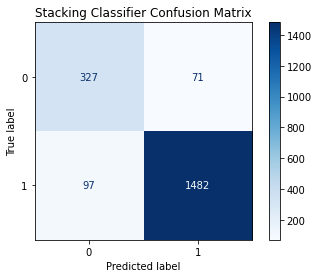

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

# Assuming `clinical_lung` is your DataFrame and `outcome` is the target column
X = clinical_lung.drop(columns=['outcome'])
y = clinical_lung['outcome']

# Handle missing values (if any)
X.fillna(X.median(), inplace=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Address class imbalance with RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Initialize base classifiers
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, reg_alpha=38, reg_lambda=69)
gb_clf = GradientBoostingClassifier(random_state=42)
ada_clf = AdaBoostClassifier(random_state=42)
svc_clf = SVC(probability=True, random_state=42)

# Define the stacking ensemble
estimators = [
    ('xgb', xgb_clf),
    ('gb', gb_clf),
    ('ada', ada_clf),
    ('svc', svc_clf)
]

# Logistic Regression as the meta-classifier
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    passthrough=True,  # Pass original features along with predictions to meta-classifier
    cv=5,  # 5-fold cross-validation
    n_jobs=-1  # Use all available cores
)

# Train the stacking classifier
stacking_clf.fit(X_train_scaled, y_train_resampled)

# Predict on the test data
y_pred = stacking_clf.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred, pos_label=1)
specificity = recall_score(y_test, y_pred, pos_label=0)
cm = confusion_matrix(y_test, y_pred)

print("Stacking Classifier Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=stacking_clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Stacking Classifier Confusion Matrix')
plt.show()


#### trying all classifiers

Stacking with LogisticRegression Performance:
Accuracy: 0.9150
Sensitivity (Recall): 0.9386
Specificity: 0.8216


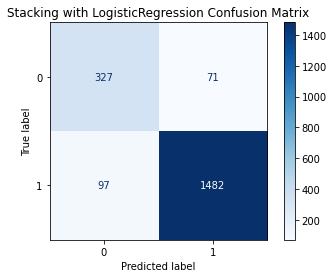

Stacking with RidgeClassifier Performance:
Accuracy: 0.9160
Sensitivity (Recall): 0.9398
Specificity: 0.8216


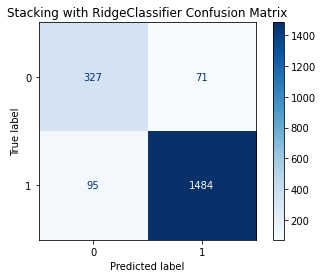

Stacking with SVC Performance:
Accuracy: 0.9110
Sensitivity (Recall): 0.9436
Specificity: 0.7814


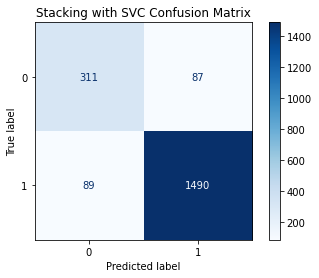

Stacking with DecisionTreeClassifier Performance:
Accuracy: 0.8938
Sensitivity (Recall): 0.9348
Specificity: 0.7312


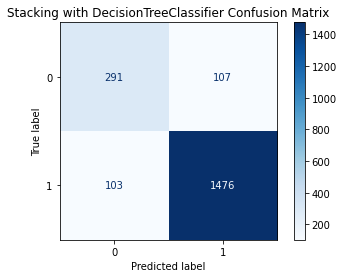

Stacking with RandomForestClassifier Performance:
Accuracy: 0.9287
Sensitivity (Recall): 0.9588
Specificity: 0.8090


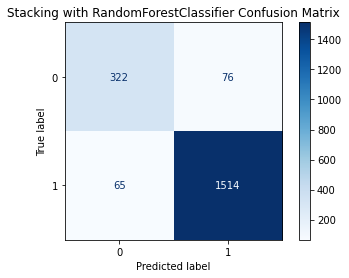

Stacking with GradientBoostingClassifier Performance:
Accuracy: 0.9186
Sensitivity (Recall): 0.9487
Specificity: 0.7990


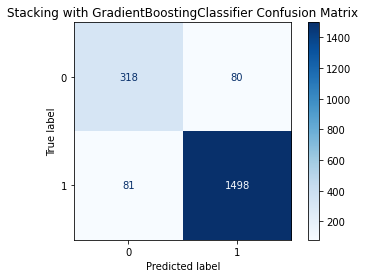

Stacking with KNeighborsClassifier Performance:
Accuracy: 0.8007
Sensitivity (Recall): 0.8296
Specificity: 0.6859


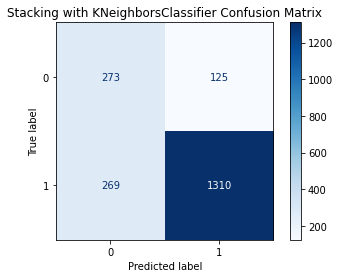

Stacking with GaussianNB Performance:
Accuracy: 0.2372
Sensitivity (Recall): 0.0488
Specificity: 0.9849


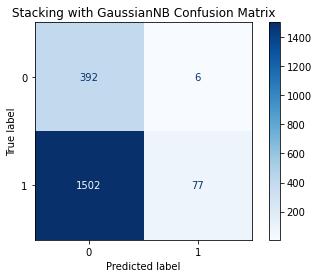

Stacking with MLPClassifier Performance:
Accuracy: 0.9150
Sensitivity (Recall): 0.9531
Specificity: 0.7638


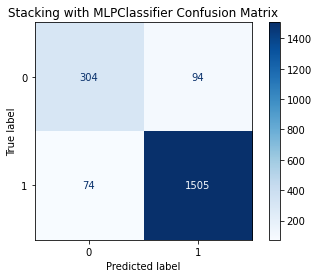

In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

# Assuming `clinical_lung` is your DataFrame and `outcome` is the target column
X = clinical_lung.drop(columns=['outcome'])
y = clinical_lung['outcome']

# Handle missing values (if any)
X.fillna(X.median(), inplace=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Address class imbalance with RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Initialize base classifiers
base_estimators = [
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, reg_alpha=38, reg_lambda=69)),
    ('gb', GradientBoostingClassifier(random_state=42)),
    ('ada', AdaBoostClassifier(random_state=42)),
    ('svc', SVC(probability=True, random_state=42))
]

# List of candidate final estimators
final_estimators = [
    LogisticRegression(max_iter=1000, random_state=42),
    RidgeClassifier(random_state=42),
    SVC(probability=True, random_state=42),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    KNeighborsClassifier(),
    GaussianNB(),
    MLPClassifier(max_iter=1000, random_state=42)
]

# Function to evaluate and display model performance
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred, pos_label=1)
    specificity = recall_score(y_test, y_pred, pos_label=0)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

# Loop through each final estimator
for final_estimator in final_estimators:
    # Define the stacking ensemble
    stacking_clf = StackingClassifier(
        estimators=base_estimators,
        final_estimator=final_estimator,
        passthrough=True,  # Pass original features along with predictions to meta-classifier
        cv=5,  # 5-fold cross-validation
        n_jobs=-1  # Use all available cores
    )
    
    # Train the stacking classifier
    stacking_clf.fit(X_train_scaled, y_train_resampled)
    
    # Evaluate the model
    model_name = final_estimator.__class__.__name__
    evaluate_model(stacking_clf, X_test_scaled, y_test, f"Stacking with {model_name}")


this doesn't improve the performance either